In [69]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
GIT_TABLE_PATH = PARENT_DIR.joinpath('.git_tables')
sys.path.append(str(PARENT_DIR))
from common_util import setup_axis_default,kbar_gl,kbar_jmak,tbar,hdi, markdown_table_from_df,_FILE_TO_LABEL as file_to_label
from typing import Callable,Tuple, List
from jax import numpy as jnp,vmap
from functools import partial
from jax import random
from jaxopt import Bisection
import warnings
from numpyro.distributions import TruncatedNormal
from numpyro.diagnostics import hpdi


SECONDS_TO_HOURS = 3600.0
HOURS_TO_YEAR = 24.0*365.0
SECONDS_TO_YEAR = SECONDS_TO_HOURS*HOURS_TO_YEAR
rng_key = random.PRNGKey(136)

In [47]:
from jax import jit

def get_temperature(time_function: Callable,
                    t: float,
                    T_bounds: Tuple = (873.15,2273.15)) -> np.ndarray:
    
    def _search_function(T: float) -> float:
        return time_function(T) - t

    return Bisection(_search_function,*T_bounds,check_bracket= False).run().params

@jit
def sample_hierarchical_jmak_model_time(X: float,
                                        T: jnp.ndarray,
                                        a1c: jnp.ndarray,
                                        a2c: jnp.ndarray,
                                        B1c: jnp.ndarray,
                                        B2c: jnp.ndarray,
                                        nc: jnp.ndarray,
                                        latent_variables: jnp.ndarray,
                                        sigma: jnp.ndarray = None) -> jnp.ndarray:
    

    Y = X if sigma is None else TruncatedNormal(X,sigma,0,1).sample(rng_key)

    a1 = a1c[0] + a1c[1]*latent_variables[0]
    a2 = a2c[0] + a2c[1]*latent_variables[1]
    B1 = B1c[0] + B1c[1]*latent_variables[0]
    B2 = B2c[0] + B2c[1]*latent_variables[1]
    n = nc[0] + nc[1]*latent_variables[0]

    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    return 1.0/b*jnp.log(1./(1. - Y))**(1/n) + t_inc

def estimate_hierarchical_model_temperature(at_time: float,
                                            T_bounds: jnp.ndarray,
                                            X: float,
                                            params_: List[jnp.ndarray]) -> jnp.ndarray:

    params = [jnp.array(param) for param in params_]
    def parameterized_function(*vparams) -> Callable:
        def temp_func(T: float) -> jnp.ndarray:
            return sample_hierarchical_jmak_model_time(X,T,*vparams)    
        
        return get_temperature(temp_func,at_time,T_bounds = T_bounds)
    
    return vmap(parameterized_function,
                     in_axes= tuple([0]*len(params)))(*params)



19.044674
-1.5686102
22.35294


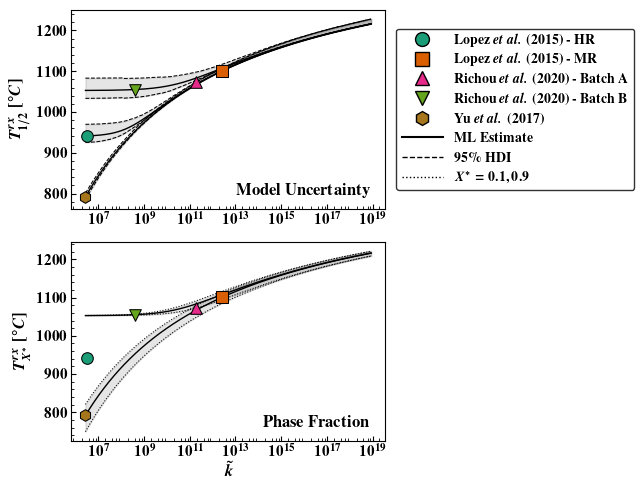

In [143]:
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, LogFormatter

model_name = 'JMAK_{}'
data_index = 1
T = np.linspace(950,1800,1000) + 273.15
fig,axes = plt.subplot_mosaic("""AC
                                 BD""", figsize = (6.5,5),
                                 width_ratios = [1,0.35])
symbols = np.array(['o','s','^','v','h'])
colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))
ax = axes['A']

with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_params.pkl'),'rb') as f:
    inf_summary = pickle.load(f)

ml_est = [inf_summary['ml'][p] for p in ['a1','a2','B1','B2','n']]
ml_est.append(inf_summary['ml']['latent_variables'][data_index])


t_param = inf_summary['ml']['latent_variables'][data_index][1]
tbar = np.array([inf_summary['ml']['latent_variables'][i][1] for i in range(inf_summary['ml']['latent_variables'].shape[0])])
kbar = np.array([inf_summary['ml']['latent_variables'][i][0] for i in range(inf_summary['ml']['latent_variables'].shape[0])])
k_param = np.linspace(kbar.min(),kbar.max() + 15,400)

def scatter_onto_axes(ax_: plt.Axes,
                      X_: float):

    ml_est_ = [ml_est[i][np.newaxis,:] for i in range(len(ml_est))]
    for i in range(inf_summary['ml']['latent_variables'].shape[0]):
        ml_est_[-1] = inf_summary['ml']['latent_variables'][i][np.newaxis,:]
        temp_ml = estimate_hierarchical_model_temperature(SECONDS_TO_YEAR,
                                                        (600 + 273.15,1900 + 273.15),
                                                        X_,
                                                        ml_est_)
        ax_.scatter(np.exp(ml_est_[-1].squeeze()[0]),
                temp_ml.squeeze() - 273.15,marker = symbols[i],color = colors[i],s = 70,
                edgecolor= 'k',lw = 0.75,zorder = 100)
        

with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_samples.pkl'),'rb') as f:
    samples = pickle.load(f)
    samples = [samples[a][::3] for a in ['a1','a2','B1','B2','n']]

X = 0.5
vec_ml_est = [
    np.repeat(ml_est[i][np.newaxis,:],len(k_param),axis = 0) for i in range(len(ml_est)-1)
]
vec_samples = [
    np.repeat(samples[i][np.newaxis,:],len(k_param),axis = 0).reshape([-1,2]) for i in range(len(samples))
]

k_samples = np.repeat(k_param[:,np.newaxis],len(samples[0]),axis = 1).reshape([-1,1])   
vec_samples.append(None)
vec_ml_est.append(None)  
for kk,t_param in enumerate([tbar[0],tbar[1],tbar[3]]):
    print(t_param)
    vec_ml_est[-1] = np.array([k_param,t_param*np.ones_like(k_param)]).T
    vec_samples[-1] = np.concat([k_samples,t_param*np.ones_like(k_samples)],axis = 1)
    ml_temp = estimate_hierarchical_model_temperature(SECONDS_TO_YEAR,
                                                            (600 + 273.15,1500 + 273.15),
                                                            X,
                                                            vec_ml_est[:])

    sampled_temp = estimate_hierarchical_model_temperature(SECONDS_TO_YEAR,
                                                            (600 + 273.15,1500 + 273.15),
                                                            X,
                                                            vec_samples[:])
    
    sampled_temp = sampled_temp.reshape([len(k_param),-1]).T
    lower,upper = hpdi(sampled_temp,0.95) 
    
    ax.plot(np.exp(k_param),ml_temp - 273.15,color = 'k',lw = 1.0)
    ax.fill_between(np.exp(k_param),lower - 273.15,upper - 273.15,alpha = 0.1,color = 'k')
    ax.plot(np.exp(k_param),lower - 273.15,linestyle = '--',color = 'k',lw = 0.75)
    ax.plot(np.exp(k_param),upper - 273.15,linestyle = '--',color = 'k',lw = 0.75)

scatter_onto_axes(ax,X)

ax = axes['B']
for t_param in [tbar[1],tbar[3]]:
    vec_ml_est[-1] = np.array([k_param,t_param*np.ones_like(k_param)]).T
    ml_temp = np.array([estimate_hierarchical_model_temperature(SECONDS_TO_YEAR,
                                                                (600 + 273.15,1500 + 273.15),
                                                                x,
                                                                vec_ml_est[:])
    for x in [0.5,0.1,0.9]] ).T
    
    ax.plot(np.exp(k_param),ml_temp[:,0] - 273.15,color = 'k',lw = 1.0)
    ax.fill_between(np.exp(k_param),ml_temp[:,1] - 273.15,ml_temp[:,2] - 273.15,alpha = 0.1,color = 'k')
    ax.plot(np.exp(k_param),ml_temp[:,1] - 273.15,linestyle = ':',color = 'k',lw = 0.75)
    ax.plot(np.exp(k_param),ml_temp[:,2] - 273.15,linestyle = ':',color = 'k',lw = 0.75)

scatter_onto_axes(ax,X)

lax = axes['C']
axes['D'].axis('off')
legend = lax.legend(
    handles=[Line2D([0], [0], marker= marker, color='w', label= r'\textbf{' + label + '}',
                    markerfacecolor=color, markeredgecolor='k', markersize=10)
             for color, label, marker in zip(colors, [a.replace('et al.',r'\textit{et al.}') for a in list(file_to_label.values())[:-1]],symbols)] + 
             [Line2D([0], [0], color = 'k', lw= 1.5, label= r'\textbf{ML Estimate}'),
              Line2D([0], [0], color = 'k', lw= 1.0, ls = '--', label= r'\textbf{95\% HDI}'),
              Line2D([0], [0], color = 'k', lw= 1.0, ls = ':', label= r'$X^*= 0.1,0.9$')],
    fontsize=10,
    loc='center',
    ncols=1,
    handlelength=3,
)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.0)


lax.axis('off')
for ax in [axes['A'],axes['B']]:
    setup_axis_default(ax)
    ax.set_xscale('log')
    ax.set_xticks(10**(np.round(np.arange(7,21,2,dtype = float))))
    ax.set_yticks(np.arange(800,1300,100,dtype = int))
    #ax.xaxis.set_major_formatter(LogFormatter(base = 10, labelOnlyBase = False))
    ax.xaxis.set_minor_locator(LogLocator(base = 10,subs = np.arange(2,10,2),numticks = 60))
    

# Add text to the bottom-right corner of axes['A']
axes['A'].text(0.95, 0.05, r'\textbf{Model Uncertainty}', transform=axes['A'].transAxes,
               fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Add text to the bottom-right corner of axes['B']
axes['B'].text(0.95, 0.05, r'\textbf{Phase Fraction}', transform=axes['B'].transAxes,
               fontsize=12, verticalalignment='bottom', horizontalalignment='right')

axes['A'].set_ylabel(r'$T^{rx}_{1/2}$ \textbf{[$^\circ C$]}',fontsize = 12)
axes['B'].set_ylabel(r'$T^{rx}_{X^*}$ \textbf{[$^\circ C$]}',fontsize = 12)
axes['B'].set_xlabel(r'$\tilde{k}$',fontsize = 12)
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('hierarchical_rx_temperature_extrapolation.svg'),bbox_inches = 'tight')
